--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price_x          1000 non-null   float64
 7   CustomerName     1000 non-null   object 
 8   Region           1000 non-null   object 
 9   SignupDate       1000 non-null   object 
 10  ProductName      1000 non-null   object 
 11  Category         1000 non-null   object 
 12  Price_y          1000 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB
None

--- Data Description ---
          Quantity   TotalValue     Price_x     Price_y
count  1000.000000  1000.000000  10

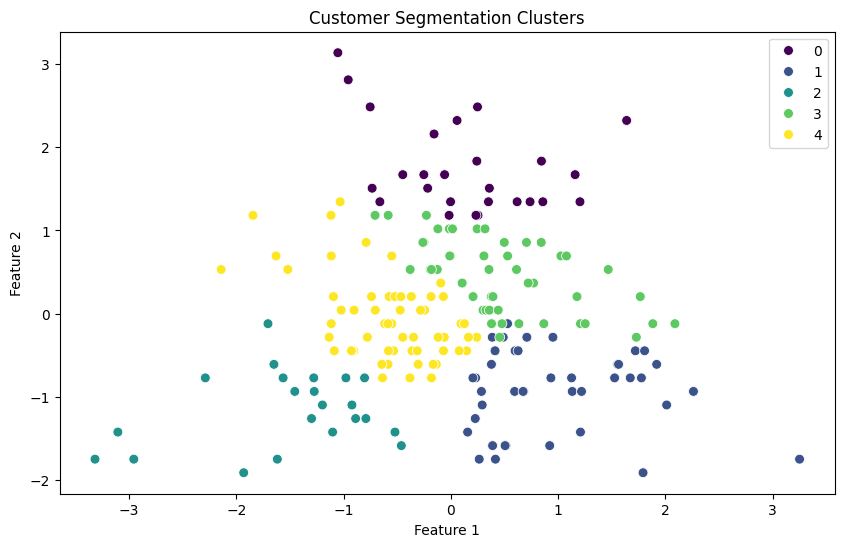


--- Clustering Results ---
Number of clusters: 5
Davies-Bouldin Index: 0.9467058109377833


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Task 1: EDA and Business Insights
# Merging datasets
data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

def perform_eda(data):
    print("--- Data Info ---")
    print(data.info())
    print("\n--- Data Description ---")
    print(data.describe())
    print("\n--- Null Values ---")
    print(data.isnull().sum())
    print("\n--- Top 5 Rows ---")
    print(data.head())


perform_eda(data)

# Business Insights
# 1. Most frequently purchased product categories and regions
most_popular_category = data['Category'].value_counts().idxmax()
most_popular_region = data['Region'].value_counts().idxmax()

# 2. Average customer spending patterns by region and product category
avg_spending_by_region = data.groupby('Region')['TotalValue'].mean().to_dict()
avg_spending_by_category = data.groupby('Category')['TotalValue'].mean().to_dict()

# 3. Peak sales periods based on transaction dates
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['Month'] = data['TransactionDate'].dt.month
peak_sales_month = data['Month'].value_counts().idxmax()

# 4. High-value customers identified based on cumulative transaction values
high_value_customers = data.groupby('CustomerID')['TotalValue'].sum().sort_values(ascending=False).head(5)

# 5. Popular products based on sales volume and revenue
popular_products = data.groupby('ProductName').agg({'Quantity': 'sum', 'TotalValue': 'sum'}).sort_values(by='Quantity', ascending=False).head(5)


print("\n--- Business Insights ---")
print(f"1. Most frequently purchased category: {most_popular_category}, Most popular region: {most_popular_region}")
print(f"2. Average spending by region: {avg_spending_by_region}")
print(f"   Average spending by category: {avg_spending_by_category}")
print(f"3. Peak sales period (month): {peak_sales_month}")
print(f"4. Top 5 high-value customers: {high_value_customers.to_dict()}")
print(f"5. Top 5 popular products: {popular_products.reset_index().to_dict('records')}")

# Task 2: Lookalike Model

data['Price'] = data['Price_x']

#similarity calculation
customer_profiles = data.groupby('CustomerID').agg({
    'Price': 'mean',
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

def compute_similarity(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.iloc[:, 1:])
    similarity_matrix = cosine_similarity(scaled_data)
    return similarity_matrix

similarity_matrix = compute_similarity(customer_profiles)

# Recommending top 3 lookalike
lookalike_results = {}
for i in range(20):
    scores = list(enumerate(similarity_matrix[i]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:4]
    lookalike_results[customer_profiles['CustomerID'][i]] = [(customer_profiles['CustomerID'][j], round(score, 2)) for j, score in scores]


lookalike_df = pd.DataFrame({"CustomerID": lookalike_results.keys(), "Lookalikes": lookalike_results.values()})
lookalike_df.to_csv('NewLookalike.csv', index=False)

# Task 3: Customer Segmentation / Clustering

clustering_data = customer_profiles.drop('CustomerID', axis=1)
scaler = StandardScaler()
scaled_clustering_data = scaler.fit_transform(clustering_data)


kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_clustering_data)
customer_profiles['Cluster'] = clusters

# Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_clustering_data, clusters)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=scaled_clustering_data[:, 0], y=scaled_clustering_data[:, 1], hue=clusters, palette='viridis', s=50
)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


print("\n--- Clustering Results ---")
print(f"Number of clusters: {kmeans.n_clusters}")
print(f"Davies-Bouldin Index: {db_index}")
